# Inter-subject Representational Similarity Analysis
*Written by Emily Finn*

“Model-free” analyses that exploit the time-locked nature of a stimulus across subjects—e.g., inter-subject correlation (ISC; [Hasson et al., 2004](https://science.sciencemag.org/content/303/5664/1634?casa_token=T_9g7N-Xu0MAAAAA:m1i9AAa80QHe_pA3xosCV-ucWhdU-0RUKQHoBr07J-5M7iUt8Clqxv5JiCwmA_WkUjboRmeBQFiAcQ)) and related approaches—are a powerful way to analyze naturalistic neuroimaging data. 

These approaches use one subject’s brain activity as a model for a second subject’s brain activity, reasoning that as long as two subjects receive the same input at the same time, any shared variance must be due to stimulus processing. If you haven't already, be sure to check out the [ISC tutorial](http://naturalistic-data.org/features/notebooks/Intersubject_Correlation.html) that is part of this book.

However, while ISC and related approaches were traditionally developed to detect responses shared at the group level, we know that brain activity during naturalistic stimuli also shows interesting individual differences.

**Q: How can we use inter-subject approaches to study what is *different*** across subjects, rather than what is common?**

One problem is that ISC by definition operates at the level of subject pairs, while traits and behaviors operate at the level of single subjects. So, how can we relate ISC (one measure per subject pair) to behavior (one measure per subject)?

**A. Representational similarity analysis!**

If we take our subjects-by-subjects ISC matrix to be a "brain similarity" matrix, we can construct a "behavioral similarity" matrix and use RSA to find brain regions where subjects who are more similar in their behavior are also more similar in their neural response. The basic idea behind this is illustrated in the figure below:

![isrsa](../../images/isrsa/Fig1_multilayer_figure_R1.jpg)

**Fig. 1. Schematic of inter-subject representational similarity analysis.**
*From [Finn et al., 2020](https://www.sciencedirect.com/science/article/pii/S1053811920303153)*. Each subject (bottom layer) is associated with a behavioral score (middle layer) and a pattern of brain activity (top layer, e.g., a time series from a given brain region during naturalistic stimulation). The middle and upper layers depict weighted graphs obtained using the similarity matrices as adjacency matrices, where thicker lines indicate increased similarity between nodes (subjects). In IS-RSA, we construct pairwise (i.e, subject-by-subject) similarity matrices for the behavioral data and the brain data, then compare these matrices using a Mantel test. Thus, we can leverage inter-subject analysis methods such as ISC to detect shared structure between brain data and behavioral data. This figure is a modified version of Fig. 1 in [Glerean et al. (2016)](https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23084).

Let's watch a short video demonstrating an application of ISRSA using social network information. 

[Dr. Carolyn Parkinson, PhD](https://people.socsci.tau.ac.il/mu/yaarayeshurun/) is an Assistant Professor at University of California Los Angeles and will discuss practical considerations for analyzing naturalistic data.

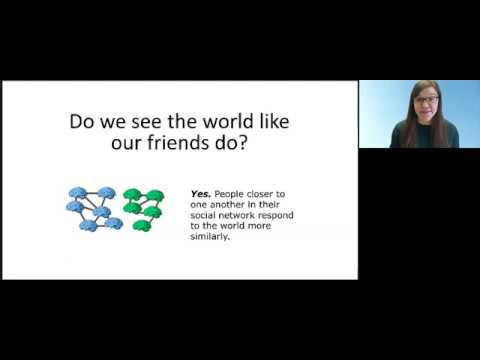

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('roG9gkTOx_U')

## Measuring similarity

How do we measure behavioral similarity? In choosing a distance metric, particularly when our behavior is one-dimensional (e.g., age ([Moraczewski et al., 2018](https://www.nature.com/articles/s41598-018-20600-0); [Richardson et al., 2018](https://www.nature.com/articles/s41467-018-03399-2)), a trait score ([Finn et al., 2018](https://www.nature.com/articles/s41467-018-04387-2)), accuracy on a cognitive task), we bake in some fundamental assumptions about the structure of the brain-behavior representational similarity that affect the ultimate results and how we interpret them. To get a feel for some potential structures, imagine arranging the rows and columns of the ISC matrix such that subjects are ordered by their behavioral score. What would we expect the resulting matrix to look like?

If we use Euclidean distance or another relative distance metric, we implicitly assume that subjects with closer scores should be more similar to one another, regardless of where they fall on the scale. In other words, for a behavior that is measured on a scale from 0 to 100, a pair of subjects scoring 0 and 1 should be just as similar as a pair of subjects scoring 99 and 100 (since in both cases, the Euclidean distance is 1). We call this the Nearest Neighbors (NN) model, since it assumes that a subject should always look most similar to his or her immediate neighbors, regardless of their absolute position on the scale.

The NN model may be appropriate for certain behaviors, but we could imagine an equally if not more plausible scenario: that similarity between subjects increases or decreases as one moves up or down the scale, in an absolute rather than relative sense. For example, perhaps high-scoring subjects are more similar to other high scorers, while low-scoring subjects are less similar both to high scorers and other low scorers. In other words, brain responses cluster together for subjects at one end of the behavioral spectrum, while variability increases as one moves toward the opposite end of the spectrum. We call this the Anna Karenina (or AnnaK) model, after the famous opening line of Leo Tolstoy’s novel, which reads “All happy families are alike; each unhappy family is unhappy in its own way” (or, in this context, “all high [low] scorers are alike; each low [high] scorer is different in his or her own way”). In this case, Euclidean distance would not be the most appropriate choice. Instead, we would want to model similarity using a metric that reflects absolute position on the scale—for example, mean: (i ​+ ​j)/2, minimum: min(i, j), or the product of the mean and minimum.

Let's do some simulations and visualizations to make this more concrete:

# Getting Started
Before getting started with this tutorial, we need to make sure you have the necessary software installed and data downloaded.

## Software
This tutorial requires the following Python packages to be installed. See the [Software Installation](http://naturalistic-data.org/features/notebooks/Software.html) tutorial for more information.

- seaborn
- matplotlib
- numpy
- scipy
- pandas
- sklearn
- nltools
- nibabel
- nilearn
- datalad

Let's now load the modules we will be using for this tutorial.

In [3]:
import os
import glob
from pathlib import Path

import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import pandas as pd
import seaborn as sns

import statsmodels.stats.multitest as smm

import nibabel as nib
from nilearn.input_data import NiftiLabelsMasker
from nilearn import plotting

from nltools.data import Brain_Data, Adjacency

from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

import datalad.api as dl

%matplotlib inline

## Data
This tutorial will be using the **Paranoia** dataset and will require downloading the cropped and denoised **nii.gz** files.

You will want to change `data_dir` to wherever you have installed the Paranoia datalad repository (e.g. `~/data`). We will initialize a datalad dataset instance and get the files we need for this tutorial. If you've already downloaded everything, you can skip this cell. See the [Download Data Tutorial](http://naturalistic-data.org/features/notebooks/Download_Data.html) for more information about how to install and use datalad.

In [ ]:
data_dir = '/Volumes/Engram/Data/Paranoia'

# If dataset hasn't been installed, clone from GIN repository
if not os.path.exists(datadir):
    dl.clone(source='https://gin.g-node.org/ljchang/Paranoia', path=datadir)

# Initialize dataset
ds = dl.Dataset(datadir)

# Get Cropped & Denoised Run 1 Nift Files
result = ds.get(glob.glob(os.path.join(datadir, 'fmriprep', '*', 'func', '*denoise_smooth6mm_task-story_run-1*nii.gz')))

### Download data

First things first, we need to download the data we'll be working with. If you haven't already installed Datalad, see [this tutorial](http://naturalistic-data.org/features/notebooks/Download_Data.html) for how to do so.

Run the below lines of code in a Terminal. The first line installs the Paranoia dataset, which basically clones the metadata of the dataset so you can see what files are available, but doesn't actually download any of the data yet.

Before you run the install, make sure you `cd` into the directory where you'd like to store the data. Here we'll only download the first run, but it will take up ~11GB overall (each run is a little over 0.5GB, and there are 22 subjects), so make sure you have enough space.

On the second line we `cd` into our newly cloned dataset directory, and on the third line we download the preprocessed run 1 for all subjects. Depending on the speed of your internet connection, this could take a little while to run -- up to a few hours, in fact. Patience is a virtue :D


`$: datalad install https://gin.g-node.org/ljchang/Paranoia` <br>
`$: cd Paranoia` <br>
`$: datalad get ./fmriprep/*/func/*denoise_smooth6mm_task-story_run-1*nii.gz`

Also make sure this notebook is located in the same parent directory as the data. So, for example, if your `Paranoia` directory from datalad is in `/Documents/naturalistic-data/Paranoia`, then this notebook should be in `/Documents/naturalistic-data/inter-subject_RSA.ipynb`.

In [2]:
# First, choose number of subjects and simulate behavior chosen from random distribution
n_subs = 100
behav_raw = np.random.randn(n_subs)
behav = sp.stats.rankdata(behav_raw)-1

cmap = plt.cm.get_cmap('RdYlBu_r')
cmap.set_bad('#C0C0C0')

# Define some helper functions
def sort_square_mtx(mtx, vct):
    """
    Sorts rows/columns of a matrix according to a separate vector.
    """
    
    inds = vct.argsort()
    mtx_sorted = mtx
    mtx_sorted = mtx_sorted[inds, :]
    mtx_sorted = mtx_sorted[:, inds]
    
    return mtx_sorted

def scale_mtx(mtx):
    """
    Scales a matrix to have values between 0 and 1.
    """
    return (mtx-np.min(mtx))/(np.max(mtx)-np.min(mtx))

First, let's see what we're assuming the similarity structure should look like if we use Euclidean distance as our metric. The matrix below is subjects-by-subjects, with subjects ordered according to behavioral score (from low to high): 

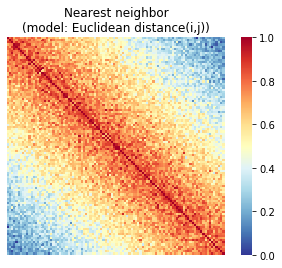

In [3]:
nn_mtx = np.zeros((n_subs, n_subs)) # initialize a similarity matrix
noise_factor = 0.1

for i in range(n_subs):
    for j in range(n_subs):
        if i < j:
            dist_ij = 1-(abs(behav[i]-behav[j])/n_subs) 
            dist_ij += np.random.randn()*noise_factor # add some random noise
            nn_mtx[i,j] = dist_ij
            nn_mtx[j,i] = dist_ij
            
nn_mtx = scale_mtx(nn_mtx)
np.fill_diagonal(nn_mtx, 1)    

fig, ax = plt.subplots()
sns.heatmap(sort_square_mtx(nn_mtx, behav), ax=ax, cmap=cmap, square=True, cbar=True, xticklabels=False, yticklabels=False)
ax.set_title("Nearest neighbor\n(model: Euclidean distance(i,j))");

So we can see that in the NN case, we see the highest similarity right along the diagonal. This means we're assuming that a subject should always look most similar to his or her immediate neighbors, regardless of where they fall on the scale more generally.

What about the "Anna K" case?

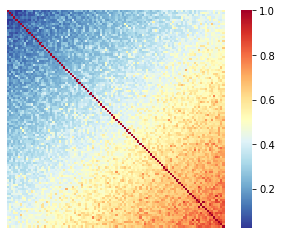

In [4]:
annak_mtx = np.zeros((n_subs, n_subs))
noise_factor = 0.1

for i in range(n_subs):
    for j in range(n_subs):
        if i < j:
            dist_ij = np.mean([behav[i]/n_subs, behav[j]/n_subs]) # calculate distance between i and j as 
            dist_ij += abs(np.random.randn()*noise_factor) # add some random noise
            annak_mtx[i,j] = dist_ij
            annak_mtx[j,i] = dist_ij

annak_mtx = scale_mtx(annak_mtx)
np.fill_diagonal(annak_mtx, 1)

fig, ax = plt.subplots()

# Draw heatmap
sns.heatmap(sort_square_mtx(annak_mtx, behav), ax=ax, cmap=cmap, square=True, cbar=True, xticklabels=False, yticklabels=False);

Now we can see that similarity increases as we move down and to the right, meaning that we expect that high scorers will look similar to other high scorers, but low scorers won't look particularly similar to one another or to high scorers.

Another way to visualize the similarity structure of these matrices is to project them into a two-dimensional embedding using t-SNE (t-Distributed Stochastic Neighbor Embedding). In the righthand panels in the figure below, each dot represents a subject, and subjects are colored according to their behavioral score. In this embedding, similar observations (in this case, subjects) appear nearby, while dissimilar observations appear further away.

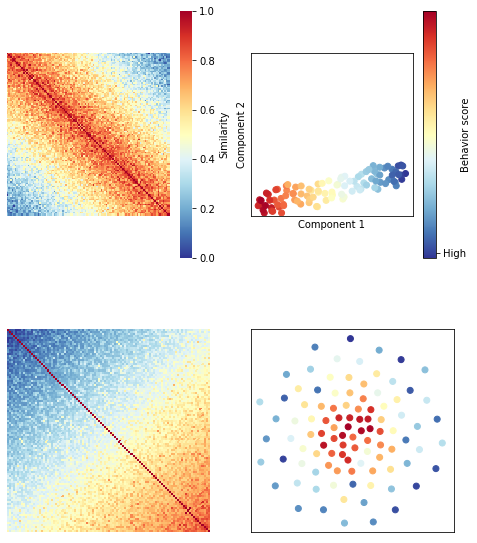

In [5]:
list_of_matrices = [nn_mtx, annak_mtx]

fig, axes = plt.subplots(len(list_of_matrices), 2, figsize = (8,10))

for m, mtx in enumerate(list_of_matrices):
    ax1 = axes[m, 0]
    ax2 = axes[m, 1]
    
    # Draw heatmap
    if m ==0:
        cbar = True
    else:
        cbar = False
        
    sns.heatmap(sort_square_mtx(mtx, behav), ax=ax1, 
                cmap=cmap, square=True, cbar=cbar, cbar_kws = {'label': 'Similarity'},
                xticklabels=False, yticklabels=False)
    
    # Draw tSNE plot
    # Note that TSNE operates on distance matrices, so because our simlarity matrices are already scaled 
    # to be between 0 and 1, we can convert easily by doing (1 – similarity matrix)
    isc_embedded = TSNE(n_components=2, metric="precomputed").fit_transform(1-mtx) 
    scatter_p = ax2.scatter(isc_embedded[:,0], isc_embedded[:,1], c=behav, cmap=cmap)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    if m ==0:
        ax2.set_xlabel('Component 1')
        ax2.set_ylabel('Component 2')
        # cbar.ax2.set_xticklabels(['Low', 'High'])
        
    ax2.axis('square')
    ax2.set(xlim = ax2.get_xlim(), ylim = ax2.get_ylim())

cbar = fig.colorbar(scatter_p, ax = axes[0,1], ticks = [-2, 2])
cbar.ax.set_yticklabels(['Low', 'High'])
cbar.set_label('Behavior score', labelpad = -5);

# Inter-subject Representational Similarity Analysis: Application

OK, so we've seen using theory and simulations that we can apply RSA to subject-wise data, and that our choice of similarity/distance metric has implications for our underlying assumptions and how we interpret results.

How much does this matter in practice? Next we're going to walk through an example of how to apply IS-RSA to the Paranoia dataset.

## Read in behavioral data

First let's read in the table that contains demographic and behavioral info on our participants:

In [6]:
behav_file = 'Paranoia/participants.tsv'
behav_data = pd.read_csv(behav_file, sep='\t')
behav_data.head()

,participant_id,age,sex,gptsa_score
0,sub-tb2994,27,M,22
1,sub-tb3132,28,F,16
2,sub-tb3240,25,M,18
3,sub-tb3279,20,M,20
4,sub-tb3512,34,M,18


In this study, the main variable of interest was trait paranoia, which was measured using the Green et al. Paranoid Thoughts Scale A ([Green et al., 2008](https://www.cambridge.org/core/journals/psychological-medicine/article/measuring-ideas-of-persecution-and-social-reference-the-green-et-al-paranoid-thought-scales-gpts/4FDC2275DF3AE6D44BF86C60AEF84CE5)). This is a self-report questionnaire that asks participants to rate how strongly they agree with statements relating to paranoid ideation over the last month. Some examples are: "I spent time thinking about friends gossiping about me", "People have been dropping hints for me", and "I was frustrated by people laughing at me." There are 16 items and each item is rated on a scale from 1 (not at all) to 5 (totally). Therefore, the minimum possible score is 16 and the maximym possible score is 80.

(Note that if you're interested in using this scale in future studies, a revised version, the [R-GPTS](https://www.cambridge.org/core/journals/psychological-medicine/article/revised-green-et-al-paranoid-thoughts-scale-rgpts-psychometric-properties-severity-ranges-and-clinical-cutoffs/1386D29D50A94FD3F2F17A56B3C5D368), has since been released.)

This was a sample of all healthy participants -- that is, no one had a diagnosis of schizophrenia or other mental illness -- so we expect most scores to be toward the low end of the spectrum. Still, trait paranoia varies even among the general population, and this study was designed to look at how normative variation in this trait relates to brain responses to an ambiguous social narrative.

(A quick aside: Measuring traits is notoriously difficult, and self-report suffers from a number of issues. Many people are working on better ways to phenotype individuals, such as using behavior [e.g., task performance] assessments, sometimes in conjunction with computational models . However, these trait measures are still commonly used. So, while we should take them with a large grain of salt, they can still be a useful starting point.)

You can see that GPTS-A scores follow a pretty skewed distribution in our sample of 22 participants, with most participants scoring fairly low and only a couple scoring higher. This is not necessarily ideal, but it's also not uncommon for a scale like this. For some analyses, we might be worried about these two extreme values driving some or all of our effects, but in RSA it's common to use rank-based similarity metrics (i.e., Spearman correlation instead of Pearson). This means that subjects are  not their absolute score, but rather their rank relative to other subjects, meaning that these two extreme scorers will not be overweighted. We'll get into this further below.

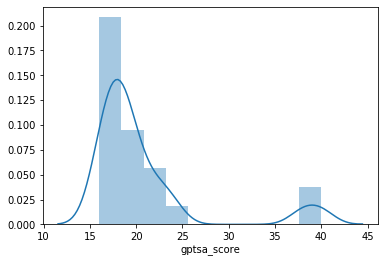

In [7]:
behav = behav_data["gptsa_score"]

sns.distplot(behav)

So for most intents and purposes, you can think of our behavior as following a uniform distribution of ranks between 1-22 (with some ties where 2 or more subjects had the same raw score):

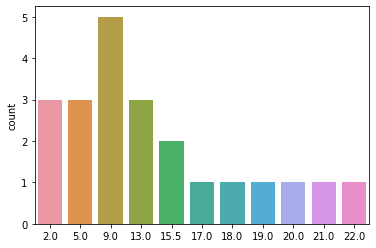

In [8]:
behav_rank = sp.stats.rankdata(behav)

sns.countplot(behav_rank)

## Read in brain data

In working with fMRI data, we have a choice as to whether we'd like to work in the original resolution of the data -- voxels -- or if we'd like to summarize across space in some way. We could calculate similarity across the whole brain at once, but there are probably some regions where the representational similarity with behavior is stronger than in other regions, and we'd like to be able to visualize and say something about which regions are contributing most to our effect. We could calculate similarity at each individual voxel separately. This has the advantage of maximizing spatial specificity, but it's also expensive in terms of time and computation, and we know the BOLD response tends to be smoother than single voxels. Another option would be to take a searchlight approach, where we calculate similarity within a "searchlight", or a relatively small sphere or cube of voxels centered around a voxel. This preserves some degree of spatial specificity while boosting signal relative to single voxels (which can be noisy) and recognizing the inherent smoothness of the local BOLD response, but it still requires us to loop through every voxel, which takes a lot of time and memory. Furthermore, both single-voxel and searchlight approaches also lead to larger penalties when it comes time to correct for multiple comparisons, since we've effectively done as many tests as there are voxels, and we need to stringently control for false positives.

A happy medium is to summarize voxelwise data into nodes, or parcels. In this approach, we used predefined ROIs to group voxels into contiguous regions. At each TR, we average signal in all the voxels in a node to get one representative timecourse for that node. This way, we cut down on computational complexity by several orders of magnitude (compare ~70,000 brain voxels in a typical 3mm<sup>3</sup> whole-brain acquisition with ~100-300 nodes found in most parcellations).

For purposes of this tutorial, we'll take the nodewise approach. We'll use a functional parcellation called the Shen atlas ([Shen et al., 2013](https://www.sciencedirect.com/science/article/abs/pii/S1053811913005818)), which has 268 nodes. I personally like this parcellation because it covers the whole brain including the subcortex and cerebellum, whereas many other parcellations only cover cortex. Also, in general, parcellations in the 200-300 node range provide a good balance of spatial specificity without having nodes so small that they amplify registration errors and partial voluming effects from slight misalignments across subjects. In general, though, I don't believe there is necessarily one "true" parcellation -- I see it more as a data-reduction step, and it's never a bad idea to make sure your results are robust to the choice of parcellation.

### Applying a parcellation mask and calculating nodewise timeseries

First, let's load our parcellation image (in the same space as our fMRI data, "TTN27"\*) and initialize a "masker" object from nilearn that will allow us to average voxels each individual node:

\*_One thing to be aware of in this dataset is that the fMRI data were normalized to the Talairach atlas (specifically the "TTN27" image available in AFNI), rather than the more common MNI space. This isn't much of an issue for purposes of this tutorial, since we plan to reduce the data into nodes and do the rest of our analyses in node rather than voxel space, but it's good to be aware of if you'd like to use the fMRI data for other purposes._

In [9]:
atlas_filename = 'shen_2mm_268_parcellation_adwarpTTN27.nii.gz'

masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)

Let's try this on the first run from the first subject to see if it's working as expected:

(526, 268)


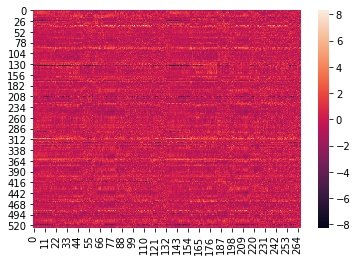

In [10]:
fmri_file = 'Paranoia/fmriprep/sub-tb2994/func/sub-tb2994_denoise_smooth6mm_task-story_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

time_series = masker.fit_transform(fmri_file)
print(time_series.shape)
sns.heatmap(time_series);

The array has the correct shape: 526 TRs (the length of run 1) x 268 nodes. When we visualize it as a heatmap we can see that the values look reasonable: centered around 0 (which we would expect given that the masker function normalizes the data by default), and no stripe-y artifacts that look *too* concerning.

Next, we'll create node time series for all subjects for all runs. There are 22 subjects, each with 3 runs, so this will take a little while. The good news is we only have to run this once -- the cell below will save the node time series as .txt files, and we can just load these directly next time we want to use them.

In [11]:
subj_list = behav_data["participant_id"]
out_dir = './nodeTimeSeries/'

for s,subj in enumerate(subj_list):    
    for run in [1, 2, 3]:

        fmri_suffix = '_denoise_smooth6mm_task-story_run-' + str(run) + '_space-MNI152NLin2009cAsym_desc-preproc_bold' 
        time_series_fname = subj + fmri_suffix + '_nodeTimeSeries.txt'
        
        if os.path.isfile(out_dir+time_series_fname): # check if time series file already exists
            print("Node time series for subject {}, run {} already exists!".format(s+1, run))
        else: # create it
            print("Creating node time series for subject {}, run {}".format(s+1, run))
            fmri_file = 'Paranoia/fmriprep/' + subj + '/func/' + subj + fmri_suffix + '.nii.gz'
            time_series = masker.fit_transform(fmri_file)
            np.savetxt(out_dir+time_series_fname, time_series)

Node time series for subject 1, run 1 already exists!
Node time series for subject 1, run 2 already exists!
Node time series for subject 1, run 3 already exists!
Node time series for subject 2, run 1 already exists!
Node time series for subject 2, run 2 already exists!
Node time series for subject 2, run 3 already exists!
Node time series for subject 3, run 1 already exists!
Node time series for subject 3, run 2 already exists!
Node time series for subject 3, run 3 already exists!
Node time series for subject 4, run 1 already exists!
Node time series for subject 4, run 2 already exists!
Node time series for subject 4, run 3 already exists!
Node time series for subject 5, run 1 already exists!
Node time series for subject 5, run 2 already exists!
Node time series for subject 5, run 3 already exists!
Node time series for subject 6, run 1 already exists!
Node time series for subject 6, run 2 already exists!
Node time series for subject 6, run 3 already exists!
Node time series for subject

Now the next time we want to work with this data, we can just load these text files containing the nodewise timeseries. As we load them, we stack them into a 3d array that is TRs x nodes x subjects:

In [12]:
run_list = [1]

subj_list = behav_data["participant_id"]
out_dir = './nodeTimeSeries/'

for s, subj in enumerate(subj_list):
    for r,run in enumerate(run_list):
    
        f_suffix = '_denoise_smooth6mm_task-story_run-' + str(run) + '_space-MNI152NLin2009cAsym_desc-preproc_bold' 
        ts_fname = subj + f_suffix + '_nodeTimeSeries.txt'
        ts = np.loadtxt(out_dir + ts_fname)
        
        if r==0:
            this_subj_data = ts
        elif r > 0:
            this_subj_data = np.vstack((this_subj_data, ts))

    if s==0:
        data = this_subj_data
    elif s>0:
        data = np.dstack((data, this_subj_data))

Let's make sure our data has the expected shape:

In [13]:
data.shape

(526, 268, 22)

526 TRs (which is the number of timepoints in Run 1) x 268 nodes x 22 subjects -- looks good.

Let's save those dimensions so we can continue to use them throughout our analysis:

In [14]:
n_trs, n_nodes, n_subs = data.shape

## Calculate brain similarity

Now that we've loaded the fMRI data for each subject, we want to compute similarity between each pair of subjects. We'll use inter-subject correlation (ISC) as our measure of brain similarity. ISC, originally proposed by Hasson et al. ([2004](https://science.sciencemag.org/content/303/5664/1634?casa_token=3oVmG98qSHgAAAAA:LXmtpfYQkGXP5GNuejgi1PpFRqrsBb0eC_jixgG_ezQt4Jnd_aEPhE9ZO6KO_lMIeSoW2vUK_T7iBw)), is the Pearson correlation of activity in the same spatial location across two or more subjects. Because all subjects heard the same time-locked story, any correlated activity across brains likely reflects processing of the stimulus.

Keep in mind that, in theory, we could calculate brain similarity based on any type of information we can extract from single subjects’ neuroimaging data. For example, we could use functional connectivity ([Glerean et al., 2016](https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23084)), or compare subjects’ temporal trajectories over the course of a stimulus using low-dimensional topological embeddings (e.g., [Gonzalez-Castillo et al., 2019](https://www.sciencedirect.com/science/article/pii/S1053811919307207?casa_token=5T27kc403nYAAAAA:N1AOdnwOScPcbvf5iIB8h6kN55DRGibCP6XsrOWell4KSIMCo6FDXAxnTX2K59jQXSxHoAtfkA); [Saggar et al., 2018](https://www.nature.com/articles/s41467-018-03664-4)), latent state discovery ([Chang et al., 2018](https://www.biorxiv.org/content/10.1101/487892v1.abstract)), or projection into a higher-order space using recurrent neural networks ([Venkatesh et al., 2019](https://www.sciencedirect.com/science/article/pii/S105381191832086X?casa_token=QTC-yPNogCoAAAAA:uMb-Hek05cjMAlRJ6msHKC3cwYQU1QuP9TSQaBky8iuLxsHt6Tr5RVkohw4SGPo2GZCrGeoQ8A)). These are all really interesting potential extensions of IS-RSA. For now, we'll use ISC because it is straightforward to compute, visualize, and interpret.

We'll calculate one ISC matrix (with dimensions subjects x subjects) for each of our 268 nodes:

In [15]:
# Use list comprehension to quickly iterate through all 268 nodes (denoted with `x`)
# The .T operator means transpose, so that we are correlating a single node's activity across all TRs, 
# rather than taking a single TR and correlating the spatial activity pattern across all nodes
# This way we end up with one ISC matrix per node, rather than one ISC matrix per TR 
# (But you can imagine the other way -- one ISC matrix per TR -- might be interesting too! 
# This alternative is sometimes referred to as 'spatial ISC' or 'inter-subject pattern correlation'

isc = [np.corrcoef(data[:,x,:].T) for x in range(n_nodes)] 

Let's make sure our `isc` data is the expected shape:

In [16]:
print(len(isc))
print(isc[0].shape)

268
(22, 22)


So `isc` is a list of length 268 (one per node) and each item in this list is a 22 x 22 matrix (subjects x subjects).

Let's visualize one of these matrices to make sure it looks reasonable:

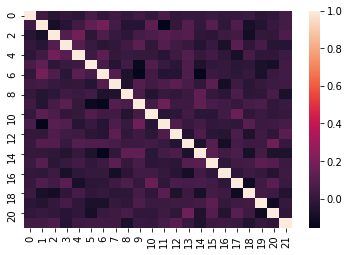

In [17]:
sns.heatmap(isc[0]);

This looks reasonable: most values are positive, and there is some variance in correlation strength across subject pairs. (The diagonal is all 1s since each subject is perfectly correlated with him or herself.)
    
Before diving into this variability across subject pairs and how it relates to behavior, we might want to see which nodes show the highest ISC across the whole group.

We'll define a function that will load in our parcellation image and color ROIs by some value -- in this case, average ISC _r_ value -- to make it easy to visualize.

(Note that even though the original data was in Talairach space, now that we've translated everything to nodes, we can easily switch back to MNI space to take advantage of nilearn's plotting functions, which use MNI space by default. To do this we just use the MNI version of the parcellation: `shen_2mm_268_parcellation.nii.gz`)

In [18]:
def color_rois(values, atlas_fname = "shen_2mm_268_parcellation.nii.gz"):
    
    """
    This function assumes you are passing a vector "values" with the same length as the number of nodes in the atlas.
    """
    
    atlas = nib.load(atlas_fname)
    atlas_data = atlas.get_data()
    img = np.zeros(atlas_data.shape)

    for roi in range(len(values)):
        itemindex = np.where(atlas_data==roi+1) # find voxels in this node (add 1 to account for zero-indexing)
        img[itemindex] = values[roi] # color them by the desired value 

    affine = atlas.affine
    img_nii = nib.Nifti1Image(img, affine)
    
    return img_nii

The ISC matrices are symmetric, so we only need to average the upper triangle (and we want to avoid including the diagonal of 1s, since this will inflate the mean values). We use numpy's handy `triu_indices_from` function to get the indices corresponding to the upper triangle of a matrix of a certain shape (in this case, 22 x 22). 

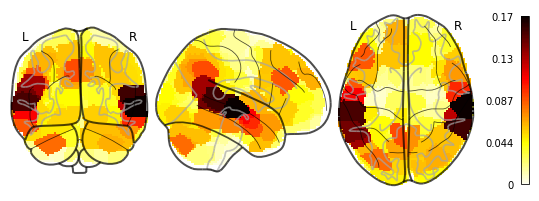

In [19]:
upp_inds = np.triu_indices_from(isc[0], k=1) # k=1 tells it to omit the diagonal

avg_isc = [np.mean(x[upp_inds]) for x in isc] # average the upper triangle

avg_isc_img = color_rois(avg_isc) # use our color_rois function to map these average ISCs onto our parcellation image

plotting.plot_glass_brain(avg_isc_img, colorbar=True); # plot it!

Happily, it looks like the highest synchrony was in superior temporal cortex, which makes sense given that these areas are involved in auditory processing and language. Visual regions aren't particularly synchronized, which also makes sense, since this was a purely audio story. But there is also some interesting synchrony in the temporo-parietal junction, anterior temporal lobe, parts of prefrontal cortex, and posterior cerebellum. This may be a hint that above and beyond receiving the same low-level auditory and linguistic input, participants' higher-level processing of the stimulus may have been somewhat similar as well.

OK, that was a good sanity check, but what we really want to know is not where there's high ISC overall, but where ISC is higher among pairs of participants that are also more similar in their behavior score.

## Calculate behavioral similarity

As we saw in the "Theory" section above, there are multiple ways to calculate behavioral similarity, and the metric we choose both implies something about our assumptions for what the similarity structure should look like and affects how we interpret the results.

Let's extract our vector of scores for the behavior we're interested in:

In [20]:
behav = behav_data["gptsa_score"]
behav_rank = sp.stats.rankdata(behav) # explicity convert the raw scores to ranks

We're going to explore both types of similarity structures presented above (nearest-neighbors and Anna Karenina) to see which one is a better fit for our data.

We'll start by calculating the "nearest neighbors" behavioral similarity matrix. The metric for this is Euclidean distance, or just the difference between two subjects' ranks. While RSA operates equally well on similarity and distance matrices, I personally find it a bit easier to keep things straight when both matrices are of the same type. Because ISC is inherently a similarity measure (higher scores = more similar), and Euclidean distance is inherently a distance measure (higher scores = more distant/less similar), we'll convert the Euclidean distances to similarities by normalizing them and subtracting them from 1. This makes it more straightforward later on, when we can interpret positive RSA _r_ values as reflecting a higher representational similarity between brain and behavior.

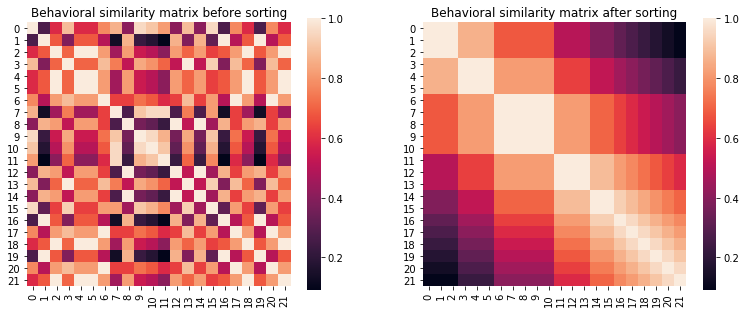

In [21]:
behav_sim_nn = np.zeros((n_subs, n_subs)) # initialize a similarity matrix to store pairwise similarities

for i in range(n_subs):
    for j in range(n_subs):
        if i < j:
            sim_ij = 1-(abs(behav_rank[i]-behav_rank[j])/n_subs) # this is essentially normalized and inverted Euclidean distance
            behav_sim_nn[i,j] = sim_ij
            behav_sim_nn[j,i] = sim_ij
        if i==j:
            behav_sim_nn[j,i] = 1

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
sns.heatmap(behav_sim_nn, ax = ax1, square=True)
ax1.set_title("Behavioral similarity matrix before sorting")
sns.heatmap(sort_square_mtx(behav_sim_nn, behav), ax = ax2, square=True)
ax2.set_title("Behavioral similarity matrix after sorting");

We can see that after sorting subjects in order of paranoia score rank (from low to high), the expected diagonal structure -- where each subject is more similar to his/her immediate neighbors -- becomes clearly visible. However, note that this matrix is **only** for purposes of visualization: for our IS-RSA analyses, we'll want to use the original matrix to make sure that the subject order matches our brain similarity (ISC) matrices!

Now we'll construct a behavioral similarity matrix reflecting the "Anna Karenina" structure. The metric for this is the mean of two subjects' ranks, which we'll normalize by the highest possible rank (the number of subjects):

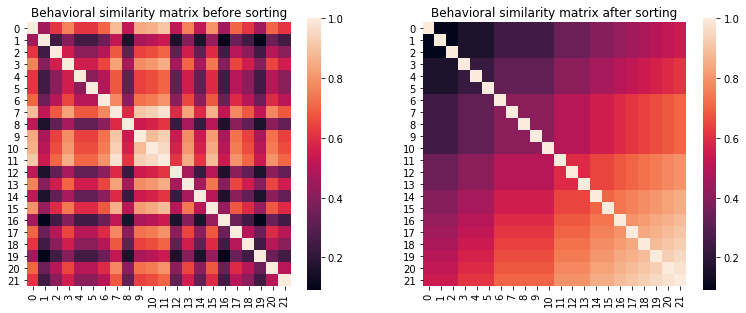

In [22]:
behav_sim_annak = np.zeros((n_subs, n_subs))

for i in range(n_subs):
    for j in range(n_subs):
        if i < j:
            sim_ij = np.mean([behav_rank[i], behav_rank[j]])/n_subs
            behav_sim_annak[i,j] = sim_ij
            behav_sim_annak[j,i] = sim_ij
        elif i==j:
            behav_sim_annak[i,j] = 1

        
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
sns.heatmap(behav_sim_annak, ax = ax1, square=True)
ax1.set_title("Behavioral similarity matrix before sorting")
sns.heatmap(sort_square_mtx(behav_sim_annak, behav), ax = ax2, square=True)
ax2.set_title("Behavioral similarity matrix after sorting");

We can see the expected structure in the sorted similarity matrix: similarity increases as you move down and to the right, reflecting the idea that pairs of participants that score higher on trait paranoia should be more similar that pairs of low-scoring participants. 

One convenient feature of operationalizing the similarity matrix in this way is that that the same model can detect effects in both directions, based on the sign of the resulting r-value between the brain and behavioral similarity matrices. If high scorers are alike and low scorers different, the resulting r-value would be positive; if low scorers are alike and high scorers different, it would be negative. This means we don't have to run two different models to check for effects in different directions.

## Relate brain similarity to behavioral similarity using RSA

Now that we have our similarity matrices for both brain and behavior data, we can do intersubject RSA!

It's easy enough to calculate a correlation coefficient between the upper triangles of two similarity matrices, but we need to be careful when assessing the statistical significance of this correlation. Parametric p-values won't work here, since the values in each matrix are not independent: each value is associated with two subjects, meaning that any two values that share a row or column are not independent. In other words, the value for (*i,j*) is not independent from the value for (*i,k*), since they share subject *i*. 

This means that we need to calculate significance non-parametrically, by randomly shuffling one of the matrices in a way that respects this complicated dependence structure. We can do this by simply making sure we permute rows and columns at the same time. One easy way to think about this is, in the case of the behavioral similarity matrix, it's as if we shuffled behavior scores across subjects and recalculated the behavioral similarity matrix. (Or, in the case of the brain similarity matrix, it's as if we shuffled node timeseries across subjects and recalculated the ISC matrix.) Then we correlate this shuffled matrix with the second matrix, and we do this a large number of times to build up a distribution for the correlation we might expect by chance. In the cells that follow, we define some functions to help us do this.

In [23]:
def matrix_correlation(data1, data2, metric='spearman'):
    
    """
    Takes two square (symmetric) matrices and returns correlation between their upper triangles.
    """

    upper_tri_inds = np.triu_indices_from(data1, 1)
    
    if metric == 'spearman':
        r = sp.stats.spearmanr(data1[upper_tri_inds], data2[upper_tri_inds])[0]
    elif metric == 'pearson':
        r = sp.stats.pearsonr(data1[upper_tri_inds], data2[upper_tri_inds])[0]

    return r

In [24]:
def permute_matrix(data, random_state=None):
    
    """ 
    Permutes rows and columns of a symmetrical matrix, preserving dependence structure.
    """
    
    random_state = check_random_state(random_state)

    data_row_id = range(data.shape[0])
    permuted_ix = random_state.choice(data_row_id,
                                      size=len(data_row_id), replace=False)
    
    return data[permuted_ix, :][:, permuted_ix]

In [25]:
def mantel_perms(data1, data2, metric='spearman', n_perms = 1000, random_state=None):
    
    """
    Permutes one of two input matrices and recalculates correlation a large number of times 
    to generate a null distribution for the expected correlation between the two matrices due to chance.
    """
        
    # Do permutation testing
    r_perm = []
    for perm in range(n_perms):
        new_data1 = permute_matrix(data1, random_state=random_state)
        r = matrix_correlation(new_data1, data2, metric=metric)
        r_perm.append(r)

    return r_perm

In [26]:
def mantel_test(data1, data2, metric='spearman', n_perms = 1000, tail = 2, random_state=None):
    
    """
    Wraps the previous 3 functions and calculates non-parametric p-value 
    by counting how many times a permuted correlation coefficient 
    exceeds the true correlation coefficient.
    
    """
        
    # Calculate observed correlation
    r_obs = matrix_correlation(data1, data2, metric=metric)
    
    # Do permutations
    r_perm = mantel_perms(data1, data2, metric=metric, n_perms=n_perms, random_state=random_state)
    
    # Calculate p-value
    denom = float(len(r_perm)) + 1
    if tail == 2:
        numer = np.sum(np.abs(r_perm) >= np.abs(r_obs)) + 1
    elif tail == 1:
        if r_obs >= 0:
            numer = np.sum(r_perm >= r_obs) + 1
        else:
            numer = np.sum(r_perm <= r_obs) + 1
    else:
        raise ValueError('tail must be either 1 or 2')
    p = numer / denom
    
    return (r_obs, p)

OK, now we're going to try this on our data. Remember that we want to run IS-RSA for every node in our atlas (268 total), so we're going to write a for-loop to help us do this, and append the resulting IS-RSA stats (r value and permutation-based p-value) to a running list called either `result_nn` or `result_annak`, depending on which distance function we're using for the behavior.

First, let's try nearest-neighbor (NN)-based similarity:

In [27]:
behav_sim = behav_sim_nn
run_list = [1]
n_perms = 10000

f_name = ''.join(['isrsa_nn_runs', ''.join(str(x) for x in run_list), '_nperms', str(n_perms)])

if os.path.isfile(f_name + '.csv'): # check if results file already exists
    print("Reading NN result from existing file")
    result_nn = pd.read_csv(f_name + '.csv')
else: # otherwise, create it
    print("Running IS-RSA using NN model")
    result_nn = []
    for node in range(n_nodes):
        print(node, end=" ")
        brain_sim = isc[:,node]
        brain_sim = sp.spatial.distance.squareform(brain_sim)
        result_nn.append(mantel_test(brain_sim, behav_sim, n_perms=n_perms))
    df = pd.DataFrame(result_nn, columns=["r_val", "p_val"])
    df.to_csv(f_name + '.csv')
    
result_nn.head()

Reading NN result from existing file


,Unnamed: 0,r_val,p_val
0,0,0.050348,0.450555
1,1,0.115661,0.092191
2,2,0.114427,0.099390
3,3,0.085473,0.191681
4,4,0.100302,0.144786


That took a little while to run. We've saved it so that if we want to use the results in the future, we won't need to rerun it.

The first thing we can do is look at the distribution of RSA r-values across all nodes, to see if there is generally some level of representational similarity between brain and behavior:

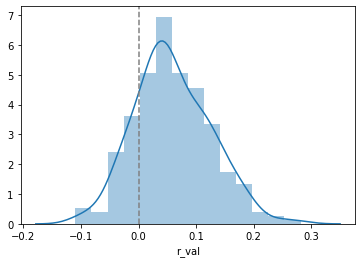

In [28]:
sns.distplot(result_nn["r_val"])

plt.gca().axvline(0, color='gray', linestyle='--');

We see that the values are generally shifted positive (the expected direction), meaning that there is more representational similarity between brain and behavior than we would expect by chance. We can also run a one-sample t-test. Note that this doesn't tell us which, if any, individual nodes show significant representational similarity, but it can tell us if there is significant representational similarity at the whole-brain level:

In [29]:
sp.stats.ttest_1samp(result_nn["r_val"], 0)

Ttest_1sampResult(statistic=14.574954924975039, pvalue=8.424580684798784e-36)

Looks like there is, in fact, significance at the whole-brain level. But we probably want to see which nodes show the highest level of representational similarity. We can do that using the same `color_rois` function that we defined above, and give it the list of RSA r-values to color nodes by:

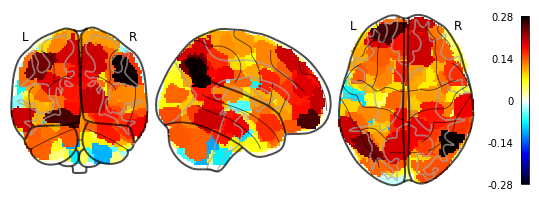

In [30]:
plotting.plot_glass_brain(color_rois(result_nn["r_val"]), plot_abs=False, colorbar=True)

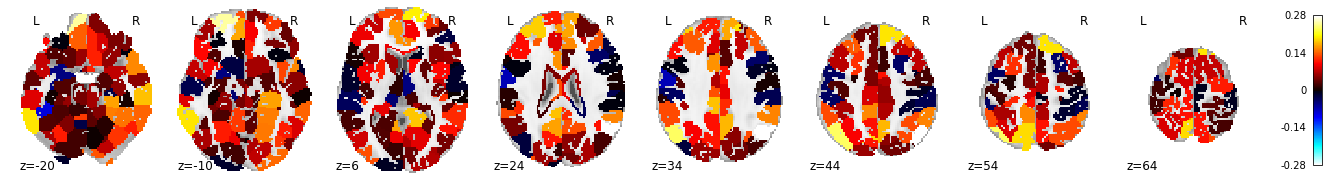

In [31]:
plotting.plot_stat_map(color_rois(result_nn["r_val"]), display_mode='z', cut_coords=8);

Interesting, it looks like some of the nodes with the highest RSA values are in the angular gyrus/temporo-parietal junction (a typical "default mode" region), and the ventromedial prefrontal cortex.

OK, now we'll try it based on AnnaK similarity:

In [32]:
behav_sim = behav_sim_annak
run_list = [1]
n_perms = 10000

df = pd.DataFrame(result_nn, columns=["r_val", "p_val"])
f_name = ''.join(['isrsa_annak_runs', ''.join(str(x) for x in run_list), '_nperms', str(n_perms)])

if os.path.isfile(f_name + '.csv'): # check if results file already exists
    print("Reading AnnaK result from existing file")
    result_annak = pd.read_csv(f_name + '.csv')
else: # otherwise, create it
    print("Running IS-RSA using AnnaK model")
    result_annak = []
    for node in range(n_nodes):
        print(node, end=" ")
        brain_sim = isc[:,node]
        brain_sim = sp.spatial.distance.squareform(brain_sim)
        result_annak.append(mantel_test(brain_sim, behav_sim, n_perms=n_perms))
    df = pd.DataFrame(result_annak, columns=["r_val", "p_val"])
    df.to_csv(f_name + '.csv')

result_annak.head()

Reading AnnaK result from existing file


,Unnamed: 0,r_val,p_val
0,0,0.202293,0.002400
1,1,0.150159,0.086891
2,2,0.193489,0.044996
3,3,0.161539,0.016598
4,4,0.115532,0.226677


We can do the same thing for the AnnaK RSA values: plot the distribution across all nodes, and run a one-sample t-test:

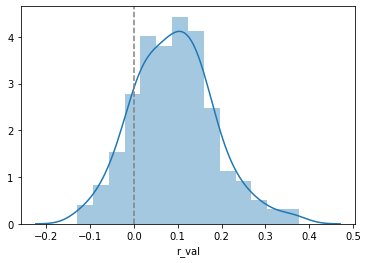

In [33]:
sns.distplot(result_annak["r_val"])

plt.gca().axvline(0, color='gray', linestyle='--');

In [34]:
sp.stats.ttest_1samp(result_annak["r_val"], 0)

Ttest_1sampResult(statistic=16.157478114353832, pvalue=1.9961732768974243e-41)

Looks like the whole-brain representational similarity is also significant with the AnnaK model. Let's plot it on the brain:

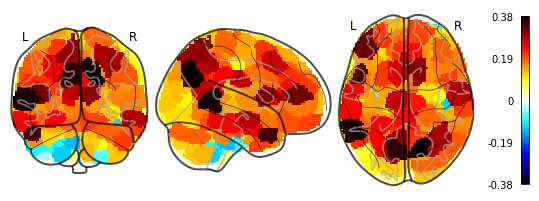

In [35]:
plotting.plot_glass_brain(color_rois(result_annak["r_val"]), plot_abs=False, colorbar=True)

Now it looks like we still see the angular gyrus, but also PCC and left temporal pole -- also regions that have been implicated in social cognition.

### Comparing different models

Now that we have run both the NN and AnnaK models, we might want to test which is more sensitive:

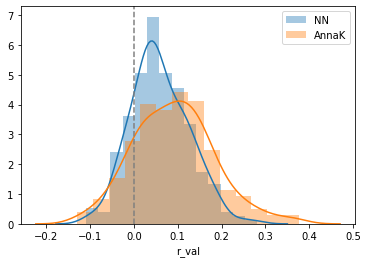

In [36]:
sns.distplot(result_nn["r_val"], label = "NN")
sns.distplot(result_annak["r_val"], label = "AnnaK")
plt.gca().axvline(0, color='gray', linestyle='--')
plt.gca().legend();

Seems like the AnnaK values are shifted right relative to the NN values. We can confirm this with a paired t-test:

In [37]:
sp.stats.ttest_rel(result_nn["r_val"], result_annak["r_val"])

Ttest_relResult(statistic=-5.739925567672386, pvalue=2.567594748575515e-08)

Another way to visually compare results from the two models is with a scatterplot. In the plot below, each dot is a node, and we also plot the identity line (where y = x, *not the regression line*). If the NN and AnnaK models gave identical results, all the dots would fall on this diagonal line. The fact that some dots are above and some dots are below means that different nodes are best fit by different models (some by NN, others by AnnaK). The fact that most of the dots are above (rather than below) the line means that overall, the AnnaK model is better for the majority of nodes.

In [38]:
def set_aspect_ratio(ax):
    
    """
    helper function to make square axes with equal x and y ranges
    """
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    both_min = np.min([xmin, ymin])
    both_max = np.max([xmax, ymax])
    ax.set_xlim((both_min, both_max))
    ax.set_ylim((both_min, both_max))
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))

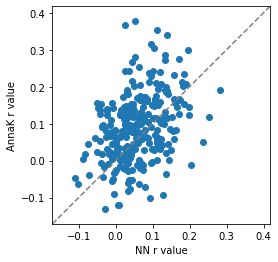

In [39]:
fig, ax = plt.subplots()

ax.scatter(result_nn["r_val"], result_annak["r_val"])

# Set up axis with identity line
line = mlines.Line2D([0, 1], [0, 1], color='gray', linestyle='--')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
set_aspect_ratio(ax)
ax.set_xlabel("NN r value")
ax.set_ylabel("AnnaK r value");

We can also compare the brain maps side-by-side:

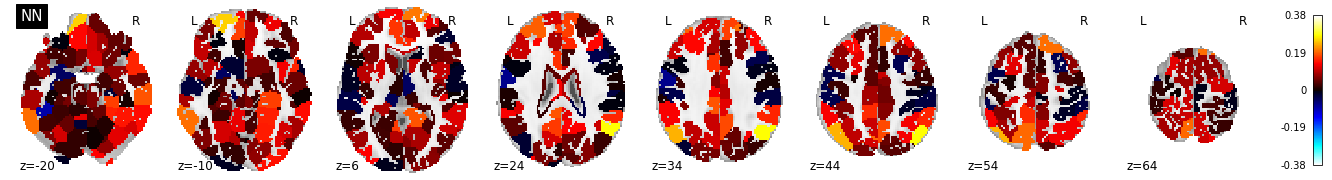

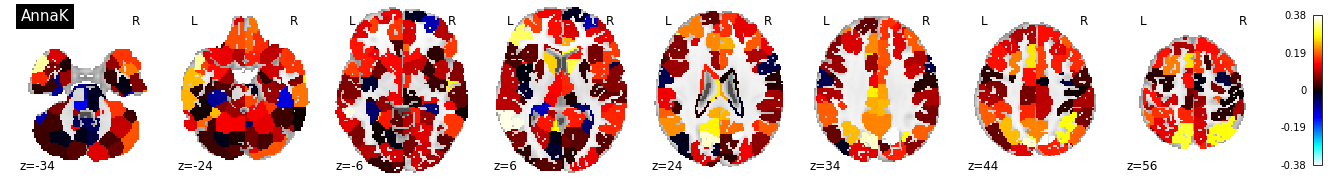

In [40]:
img_nn = color_rois(result_nn["r_val"])
img_annak = color_rois(result_annak["r_val"])

# Find the max absolute magnitude r_val across both sets of results so we can plot using the same colorscale
vmax = np.max(np.abs([result_nn["r_val"], result_annak["r_val"]]))

plotting.plot_stat_map(img_nn, display_mode='z', cut_coords=8, vmax=vmax, title = "NN")
plotting.plot_stat_map(img_annak, display_mode='z', cut_coords=8, vmax=vmax, title = "AnnaK");

### Correcting for multiple comparisons

If we want to make inferences about the significance of representational similarity at individual nodes, we need to correct for multiple comparisons (since for each model we've run 268 tests -- one for each node). We could use Bonferroni correction, where we divide our alpha threshold (typically 0.05) by the number of tests we've run (268) to get a corrected alpha threshold (in this case 0.05/268 = 0.00019), but this is probably too conservative, resulting in many false negatives. An alternative is to use the false discovery rate method (FDR) to give us better power.

We can use the implementation available in the Python package `statsmodels` to do FDR correction. This returns two arrays of length 268 (one per test, or node in this case): a Boolean indicating whether this node is significant after correction (using, in this case, the default alpha value of 0.05; `rej_null`), and the actual corrected *p* value (`p_corr`).

First we'll do it for the results from the NN model:

In [41]:
rej_null_nn, p_corr_nn = smm.multipletests(result_nn["p_val"], method='fdr_bh')[:2]

In [42]:
rej_null_nn.sum()

0

Unfortunately it seems like none of our nodes survive multiple comparisons correction. We can also look at a histogram of corrected *p* values and see that many are on the higher end of the distribution:

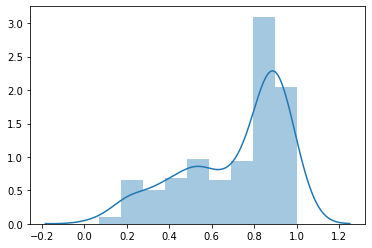

In [43]:
sns.distplot(p_corr_nn)

How about for the AnnaK model?

In [44]:
rej_null_annak, p_corr_annak = smm.multipletests(result_annak["p_val"], method='fdr_bh')[:2]

In [45]:
rej_null_annak.sum()

0

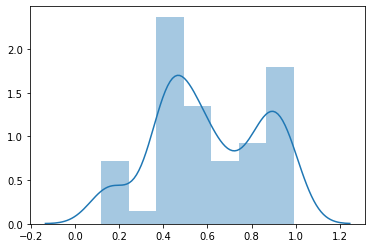

In [46]:
sns.distplot(p_corr_annak)

Unfortunately it seems like none of the nodes survive multiple comparisons correction using the AnnaK model either (though there are a few that are close).

Why might this be? It's likely a lack of power: with only 22 subjects, it's difficult to detect brain-behavior relationships.

In the [original paper](https://www.nature.com/articles/s41467-018-04387-2), we took a voxelwise approach, which greatly increased computational complexity -- and the number of tests -- but also allowed us to take advantage of cluster-based correction, which is another way to control the family-wise error rate that leverages the spatial structure of the data (based on the assumption that if many contiguous voxels are significant, it's unlikely to be due to chance). One tradeoff with using nodes is that we are not able to use cluster correction or other spatial methods. 

In any case, we hope this has still been a useful discussion of the concepts behind inter-subject RSA and demonstration of how to apply this method to a real dataset. There are some publicly available datasets that include both naturalistic fMRI data and phenotyping data on larger numbers of subjects than what is available in the Paranoia dataset. These include:

- [Human Connectome Project 7T movie-watching data](https://www.humanconnectome.org/study/hcp-young-adult) (n = 184, four 15-minute movie-watching runs, many cognitive, affective, and clinical measures)
- [Child Mind Institute Health Brain Network project](http://fcon_1000.projects.nitrc.org/indi/cmi_healthy_brain_network/index.html) (n = 2,500+ and growing, two movie-watching runs [one 10-minute and one 3.5-minute], many cognitive, affective, and clinical measures)

If you know of others, please submit a pull request and add them here!

# More resources on IS-RSA and RSA in general

Many of the ideas presented here come from this paper:
- [E. S. Finn, E. Glerean, A. Y. Khojandi, D. Nielson, P. J. Molfese, D. A. Handwerker, P. A. Bandettini. Idiosynchrony: From shared responses to individual differences during naturalistic neuroimaging. *NeuroImage,* 215, 2020](https://www.sciencedirect.com/science/article/pii/S1053811920303153)

If this tutorial was useful to you, please consider citing this paper in addition to the [naturalistic-data-analysis book](http://naturalistic-data.org/intro). Thanks!

Here are some other great resources for learning more about how RSA is generally used in brain imaging:
- [N. Kriegeskorte, M. Mur, P. Bandettini. Representational similarity analysis - connecting the branches of systems neuroscience. *Front. Syst. Neurosci.,* 2 (2008)](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full?utm_source=FWEB&utm_medium=NBLOG&utm_campaign=ECO_10YA_top-research)
- [N. Kriegeskorte, R.A. Kievit. Representational geometry: integrating cognition, computation, and the brain. *Trends Cognit. Sci.,* 17 (2013), pp. 401-412](https://www.sciencedirect.com/science/article/pii/S1364661313001277)
- [H. R. Dimsdale-Zucker, C. Ranganath. Chapter 27 - Representational Similarity Analyses: A Practical Guide for Functional MRI Applications, *Handbook of Behavioral Neuroscience,* Editor(s): Denise Manahan-Vaughan, Elsevier, Volume 28, 2018](https://www.sciencedirect.com/science/article/pii/B9780128120286000276)
- Luke Chang's [RSA tutorial](https://dartbrains.org/features/notebooks/14_RSA.html) for the [dartbrains project](https://dartbrains.org/intro)
- Mark Thornton's [lecture](https://www.youtube.com/watch?v=ufGtuT_J75w&index=29&t=0s&list=PLEE6ggCEJ0H0KOlMKx_PUVB_16VoCfGj9) and [tutorial](https://github.com/Summer-MIND/mind_2018/tree/master/tutorials/representational_similarity) at the [Methods in Neuroscience at Dartmouth (MIND) Summer School 2018](https://mindsummerschool.org/2018/07/30/narratives-and-naturalistic-contexts.html)

And here are some cool papers using IS-RSA methods:
- [van Baar, J.M., Chang, L.J. & Sanfey, A.G. The computational and neural substrates of moral strategies in social decision-making. Nat Commun 10, 1483 (2019).](https://www.nature.com/articles/s41467-019-09161-6)
- [David C. Gruskin, Monica D. Rosenberg, Avram J. Holmes. Relationships between depressive symptoms and brain responses during emotional movie viewing emerge in adolescence. NeuroImage, 216 (2020)](https://www.sciencedirect.com/science/article/pii/S1053811919308080)
- [P. A. Chen, E. Jolly, J. H. Cheong, . J. Chang. Intersubject representational similarity analysis reveals individual variations in affective experience when watching erotic movies. NeuroImage, 216 (2020)](https://www.sciencedirect.com/science/article/pii/S1053811920303372)
- [L. Nummenmaa, E. Glerean, M. Viinikainen, I. P. Jääskeläinen, R. Hari, M. Sams. Emotions promote social interaction by synchronizing brain activity across individuals. Proceedings of the National Academy of Sciences, Jun 2012, 109 (24) 9599-9604](https://www.pnas.org/content/109/24/9599.short)
- [Jääskeläinen, I., Pajula, J., Tohka, J. et al. Brain hemodynamic activity during viewing and re-viewing of comedy movies explained by experienced humor. Sci Rep 6, 27741 (2016).](https://www.nature.com/articles/srep27741)
- [S. Tei, J.-P. Kauppi, J. Fujino, K. F. Jankowski, R. Kawada, T. Murai, H. Takahashi. Inter-subject correlation of temporoparietal junction activity is associated with conflict patterns during flexible decision-making. Neuroscience Research, 144 (2019)](https://www.sciencedirect.com/science/article/pii/S016801021830244X)
- [M. Nguyen, T. Vanderwal, U. Hasson. Shared understanding of narratives is correlated with shared neural responses. NeuroImage, 184 (2019)](https://www.sciencedirect.com/science/article/pii/S1053811918307948)
- [Saalasti, S, Alho, J, Bar, M, et al. Inferior parietal lobule and early visual areas support elicitation of individualized meanings during narrative listening. Brain Behav. 2019; 9:e01288.](https://onlinelibrary.wiley.com/doi/full/10.1002/brb3.1288)
- [M. Bacha-Trams, Y. I. Alexandrov, E. Broman, E. Glerean, M. Kauppila, J. Kauttonen, E. Ryyppö, M. Sams, I. P. Jääskeläinen. A drama movie activates brains of holistic and analytical thinkers differentially. Social Cognitive and Affective Neuroscience, 13 (2018)](https://academic.oup.com/scan/article/13/12/1293/5168059)

# Contributions
 Emily Finn wrote the tutorial. Luke Chang edited text and code.